In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from io import StringIO

#### Data Import and Cleaning!

In [2]:
# reformat the CSV to use | instead of , to separate rows, then import [a selection] of the data as a dataframe
for_pd = StringIO()
with open('../data/accre-jobs-2020.csv') as accre:
    for line in accre:
        new_line = re.sub(r',', '|', line.rstrip(), count=12)
        print (new_line, file=for_pd)
for_pd.seek(0)
accre_df = pd.read_csv(for_pd, sep='|')#[1000000:1005000] # add this to subset

In [3]:
# Changing NODES and CPUS to integers

accre_df['NODES'] = accre_df['NODES'].astype(int)
accre_df['CPUS'] = accre_df['CPUS'].astype(int)

##### Converting all times to seconds

In [4]:
## This splits the hour, minutes, seconds from the __TIME columns
accre_df['hours_min_sec_req'] = accre_df['REQTIME'].str[-8:]
accre_df['hours_min_sec_used'] = accre_df['USEDTIME'].str[-8:]

## This splits the day from the ___TIME columns
accre_df['day_req'] = accre_df['REQTIME'].str.extract('(.*?)-')
accre_df['day_used'] = accre_df['USEDTIME'].str.extract('(.*?)-')

## Adds zeros to the day column where null
accre_df['day_req'] = accre_df['day_req'].fillna(0)
accre_df['day_used'] = accre_df['day_used'].fillna(0)

# Converting days to integers to use in converting to seconds
accre_df['day_req'] = accre_df['day_req'].astype(int)
accre_df['day_used'] = accre_df['day_used'].astype(int)

# Converting to timedelta
accre_df['hours_min_sec_req'] =  pd.to_timedelta(accre_df['hours_min_sec_req'], unit='s')
accre_df['hours_min_sec_used'] =  pd.to_timedelta(accre_df['hours_min_sec_used'], unit='s')

# Using timedeltas to then use dt.total_seconds()
accre_df['hours_min_sec_req'] = accre_df['hours_min_sec_req'].dt.total_seconds()
accre_df['hours_min_sec_used'] = accre_df['hours_min_sec_used'].dt.total_seconds()

In [5]:
# Create total seconds columns 
accre_df['total_sec_req'] = (accre_df['day_req'] * 86400) + accre_df['hours_min_sec_req']
accre_df['total_sec_used'] = (accre_df['day_used'] * 86400) + accre_df['hours_min_sec_used']

# Question 1:

While we have systematic checks in place to ensure the general system health of each compute node, we would like to use long-term data to see if there are any clusters of job failures on specific nodes. Do any of the production partition nodes show an unusual number of failed jobs relative to the others? Ignore the debug partition for this question.

In [6]:
# Creating new dataframe subsetted to failed jobs and those found in the production partition

accre_df_failures = accre_df[
    (accre_df['STATE'] == 'FAILED') &
    (accre_df['PARTITION'] == 'production')
]

accre_df_failures = accre_df_failures.reset_index()

In [7]:
# Let's see how much data we have now
accre_df_failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               500 non-null    int64  
 1   JOBID               500 non-null    object 
 2   ACCOUNT             500 non-null    object 
 3   USER                500 non-null    object 
 4   REQMEM              500 non-null    object 
 5   USEDMEM             500 non-null    object 
 6   REQTIME             500 non-null    object 
 7   USEDTIME            500 non-null    object 
 8   NODES               500 non-null    int64  
 9   CPUS                500 non-null    int64  
 10  PARTITION           500 non-null    object 
 11  EXITCODE            500 non-null    object 
 12  STATE               500 non-null    object 
 13  NODELIST            500 non-null    object 
 14  hours_min_sec_req   500 non-null    float64
 15  hours_min_sec_used  500 non-null    float64
 16  day_req 

We started with 3,816,290 in our dataset and are now down to 500 after whittling it down to failures in the production partition. This is a failure rate of .01%

In [8]:
# Creating DF to plot by node using value_counts.  Will also rename the axis and reset the index
failures_by_nodelist = accre_df_failures['NODELIST'].value_counts().rename_axis('NODELIST').reset_index(name='FAILURES')

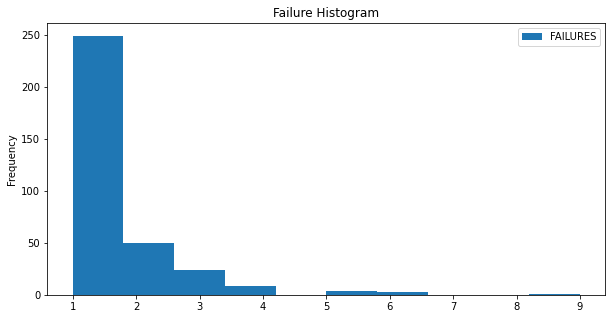

In [9]:
failures_by_nodelist.plot(kind = 'hist', title = 'Failure Histogram', figsize = (10, 5));

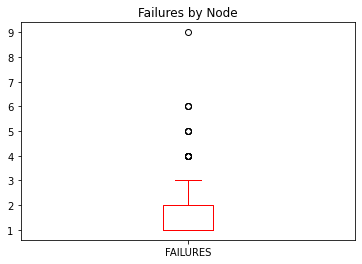

In [10]:
failures_by_nodelist.plot(kind='box', color='red', title='Failures by Node');

In [11]:
failures_by_nodelist.describe()

,FAILURES
count,339.000000
mean,1.474926
std,1.009624
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,9.000000


In [12]:
# Node(s) that fail 3 or more times are considered outliers
failures_by_nodelist[failures_by_nodelist['FAILURES'] > 3]

,NODELIST,FAILURES
0,cn1273,9
1,cn304,6
2,cn1364,6
3,cn1458,6
4,cn[1530-1531],5
5,cn1450,5
6,cn1270,5
7,cn1479,5
8,cn1436,4
9,cn1267,4


It may be worth double checking these nodes!

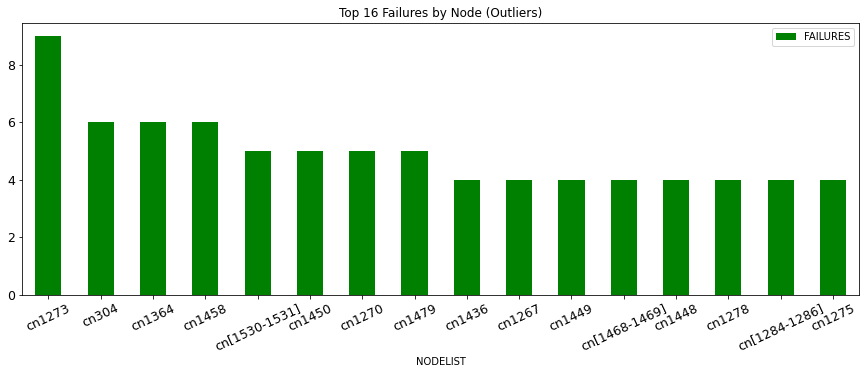

In [13]:
# Visualization of the top failing nodes
failures_by_nodelist.head(16).plot(
    kind = 'bar', 
    x = 'NODELIST',
    y = 'FAILURES',
    title = 'Top 16 Failures by Node (Outliers)',
    color = 'green', 
    figsize = (15,5),
    rot = 25, 
    fontsize = 12.5
);

#### After investigating the reason for failure by Exit Code, it was found that every failure was due to user error. It seems the systematic checks are performing as expected. That said, we want to see which accounts have many failures from user error as a potential opportunity for further training

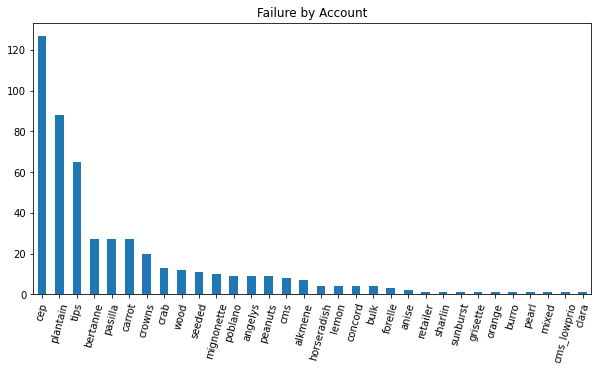

In [14]:
# Bar chart of failure by account
accre_df_failures['ACCOUNT'].value_counts().plot(kind ='bar', title = 'Failure by Account', figsize=(10,5), rot=75);

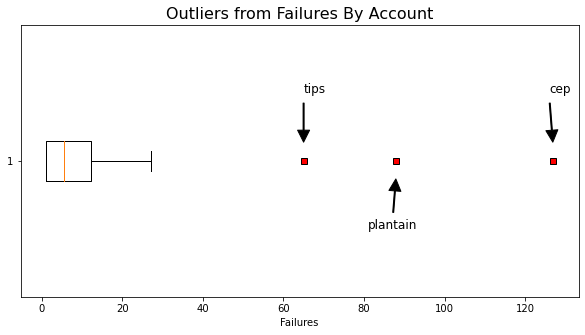

In [15]:
# Create DF for failures by account and use box plot to identify outliers
accre_df_failures_by_account = accre_df_failures['ACCOUNT'].value_counts()

red_square = dict(markerfacecolor='r', marker='s')

plt.figure(figsize = (10,5))
plt.title('Outliers from Failures By Account', fontsize=16)
plt.xlabel('Failures')
plt.annotate(s = 'cep', xy = (127, 1.05), fontsize = 12,
             xytext = (126, 1.25), arrowprops=dict(facecolor='black', shrink=0.1, width=1))
plt.annotate(s = 'plantain', xy = (88, .95), fontsize = 12,
             xytext = (81, .75), arrowprops=dict(facecolor='black', shrink=0.1, width = 1))
plt.annotate(s = 'tips', xy = (65, 1.05), fontsize = 12,
             xytext = (65, 1.25), arrowprops=dict(facecolor='black', shrink=0.1, width = 1))
plt.boxplot(accre_df_failures_by_account,  
            vert = False, 
            flierprops=red_square);

The accounts cep, plantain, and tips are failing the most due to user error. I'd suggest reaching out to them to see if they need additional help when running jobs!

# Question 2
The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot". For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes. Do any of their jobs that ended in under an hour also cluster on specific compute nodes, suggesting possbily unreliable systems? Check both “production” and “nogpfs” partitions. Look for commonly failing nodes and compare with other failed jobs.

In [16]:
#subsetting data for cms account
cms_df = accre_df[accre_df['ACCOUNT']=='cms']

#subsetting data to get rid of debug partition
cms_df = cms_df[cms_df['PARTITION']!='debug']

#subsetting data for only 'cmspilot' and 'cmslocal' users
cms_df = cms_df[(cms_df['USER']=='cmspilot')|(cms_df['USER']=='cmslocal')]

#printing how many CMS jobs including over an hour
print(cms_df.shape)

#subsetting for time under an hour
cms_df = cms_df[cms_df['total_sec_used'] <= 3600]

#getting only failed jobs
#using state != to complete instead of exit code beacuse its built in their code to crash and error might not be reflected in exit code
cms_failed = cms_df[cms_df['STATE'] != 'COMPLETED']
cms_completed = cms_df[cms_df['STATE'] == 'COMPLETED']

(699831, 19)


#### EDA and Analysis

In [17]:
#Examining the difference between a 'COMPLETED' job and exitcode '0:0'
pd.crosstab(cms_df['EXITCODE'],cms_df['STATE']).apply(lambda x: (x/x.sum()), axis=1)

STATE,CANCELLED,CANCELLED by 9201,CANCELLED by 9202,COMPLETED,FAILED,RUNNING
EXITCODE,,,,,,
0:0,0.003442,0.000007,0.000007,0.996388,0.000000,0.000157
0:9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
127:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1:0,0.733333,0.000000,0.000000,0.000000,0.266667,0.000000


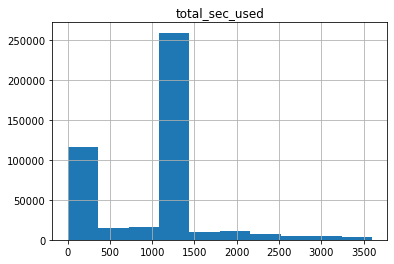

In [18]:
#Looking at distribution of seconds to find spike
#where jobs are canceling sround 30 min
cms_df.hist(column = 'total_sec_used');

In [19]:
#How many jobs ended between 500 and 2000 seconds
#or 1000 and 1500 use this one second spike
cms_jobs_ended_around_30_min = cms_df[(cms_df['total_sec_used'] < 1500) & (cms_df['total_sec_used'] > 1000)]

print("Number of CMS Jobs Total:")
print("(699831, 19)")
print("Number of CMS Jobs Under Hour:")
print(cms_df.shape)
print("Number of CMS Jobs Ended Around 30 Minutes:")
print(cms_jobs_ended_around_30_min.shape)

Number of CMS Jobs Total:
(699831, 19)
Number of CMS Jobs Under Hour:
(447255, 19)
Number of CMS Jobs Ended Around 30 Minutes:
(263645, 19)


In [20]:
#what percent of jobs is this?
print(str(round((263645/699831)*100,2)) + "% are ending around 30 minutes\nout of total CMS jobs (cmspilot/cmslocal users)")
print("\n")
print(str(round((263645/447255)*100,2)) + "% are ending around 30 minutes\nout of jobs ending in less than an hour")

37.67% are ending around 30 minutes
out of total CMS jobs (cmspilot/cmslocal users)


58.95% are ending around 30 minutes
out of jobs ending in less than an hour


#### Most failed nodes for CMS

Text(0, 0.5, 'Number of Time Failed')

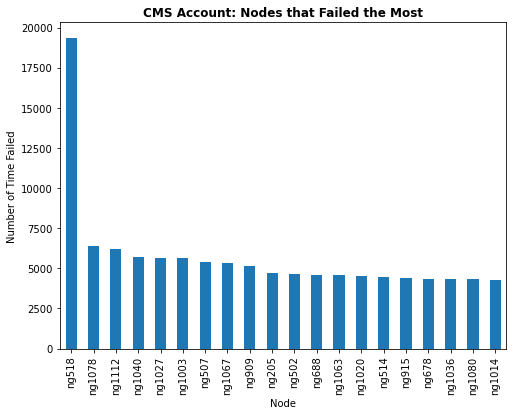

In [21]:
most_failed_nodes = cms_df['NODELIST'].value_counts().head(20)
ax = most_failed_nodes.plot(kind = 'bar', figsize = (8,6))
ax.set_title('CMS Account: Nodes that Failed the Most',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Number of Time Failed')

In [22]:
#Count of failed nodes for new df for percents
cms_failed['NODELIST'].value_counts().head()

ng518     16
cn1314    12
cn394     11
ng734     10
ng1112     9
Name: NODELIST, dtype: int64

In [23]:
#Count of successful nodes for new df for percents
cms_completed['NODELIST'].value_counts().head()

ng518     19336
ng1078     6382
ng1112     6162
ng1040     5671
ng1027     5640
Name: NODELIST, dtype: int64

In [24]:
#Creating df with top nodes to examine by percent of times failed
CMS_nodes = {'NODE':['ng518','cn1314','cn394','ng734','cn475','cn1094','ng1112','cn449','cn1121','cn304','cn1394','cn408','cn1387','cn399','cn363','cn429','cn1398','cn312'],
            'TIMES_FAILED':[16,12,11,10,9,9,9,9,9,9,8,8,8,8,8,8,8,8],
            'TOTAL_TIMES_USED':[19352,12,347,4138,364,397,6171,400,465,298,408,446,249,415,339,306,550,407]}
CMS_nodes_df = pd.DataFrame(CMS_nodes, columns = ['NODE','TIMES_FAILED','TOTAL_TIMES_USED'])

In [25]:
CMS_nodes_df['PERCENT_FAILED'] = (CMS_nodes_df['TIMES_FAILED']/CMS_nodes_df['TOTAL_TIMES_USED'])*100

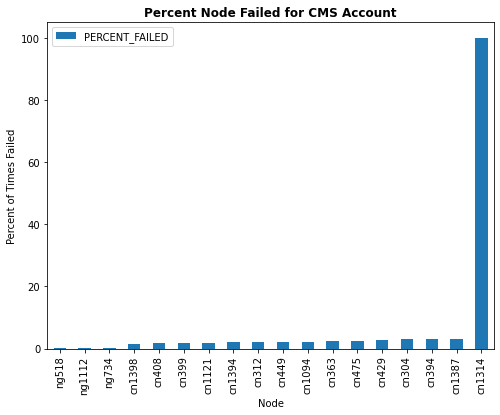

In [26]:
#plotted with one outlier, maybe remove it to make it easier to see
ax = CMS_nodes_df.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED', figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed');

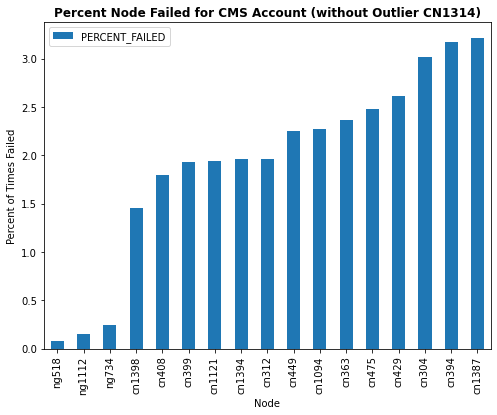

In [27]:
#removed cn 1314 to make it to make it easier to see,  label this graph
CMS_nodes_without_cn1314 = CMS_nodes_df[CMS_nodes_df['NODE'] != 'cn1314']
ax = CMS_nodes_without_cn1314.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED',figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account (without Outlier CN1314)',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed');

In [28]:
CMS_nodes_df.sort_values('PERCENT_FAILED', ascending = False).head()

,NODE,TIMES_FAILED,TOTAL_TIMES_USED,PERCENT_FAILED
1,cn1314,12,12,100.000000
12,cn1387,8,249,3.212851
2,cn394,11,347,3.170029
9,cn304,9,298,3.020134
15,cn429,8,306,2.614379


# Question 3
What groups are best optimizing their memory usage in terms of percent of actual memory used of the memory requested for a job? What is the average percent for each group?

In [29]:
# Create new DF subset to exit code 0:0 and production partition
accre_df_mem = accre_df
accre_df_mem = accre_df_mem[
    (accre_df['EXITCODE'] == '0:0') &
    (accre_df['PARTITION'] == 'production')
]

In [30]:
# Drop unnecessary columns, set axis = 1 to specify dropping columns
accre_df_mem = accre_df_mem.drop(['JOBID','USER', 'REQTIME', 'USEDTIME', 'hours_min_sec_req', 'hours_min_sec_used','day_req', 'day_used', 'NODELIST'], axis =1) 

In [31]:
#new column is for requested memory per node
accre_df_mem['RMPN'] = accre_df_mem['REQMEM'].str.extract('(.*)Mn$')

#new column is for requested memory per core
accre_df_mem['RMPC'] = accre_df_mem['REQMEM'].str.extract('(.*)Mc$')

#new column is for requested memory per core
accre_df_mem['UM'] = accre_df_mem['USEDMEM'].str.extract('(.*)M$')

In [33]:
# change RMPC,RMPN,UM columns to fill NaNs with a 0
accre_df_mem['RMPC'] = accre_df_mem['RMPC'].fillna('0')
accre_df_mem['RMPN'] = accre_df_mem['RMPN'].fillna('0')
accre_df_mem['UM'] = accre_df_mem['UM'].fillna('0')

In [34]:
#fixing types
accre_df_mem['RMPC']= accre_df_mem['RMPC'].astype(str).astype(float)
accre_df_mem['RMPN']= accre_df_mem['RMPN'].astype(str).astype(float)
accre_df_mem['UM']= accre_df_mem['UM'].astype(str).astype(float)

In [35]:
# what is per core??? assume you multiply cpus by node this column will be RMPN times CPUS 
#3.5 is the average node to core ratio
accre_df_mem['RMPN'] = accre_df_mem['RMPN'] /(accre_df_mem['CPUS']/ accre_df_mem['NODES'])

In [36]:
# what is per core??? update RMPC to add the RMPNEW column
accre_df_mem['RMPC'] = accre_df_mem['RMPC'] + accre_df_mem['RMPN']

# remove unneeded columns
accre_df_mem = accre_df_mem.drop(["RMPN"], axis =1)

In [37]:
#convert used memory to cores 
accre_df_mem['UM'] = (accre_df_mem['UM'] /accre_df_mem['CPUS'])/ accre_df_mem['NODES']

In [38]:
# PERCENT of request to actual used
accre_df_mem['PRU'] = (accre_df_mem['UM']/accre_df_mem['RMPC']) * 100

In [39]:
accre_df_mem.head()

,ACCOUNT,REQMEM,USEDMEM,NODES,CPUS,PARTITION,EXITCODE,STATE,total_sec_req,total_sec_used,RMPC,UM,PRU
0,treviso,122880Mn,65973.49M,1,24,production,0:0,COMPLETED,1188000.0,1188028.0,5120.0,2748.895417,53.689364
1,treviso,122880Mn,67181.12M,1,24,production,0:0,COMPLETED,1188000.0,1090256.0,5120.0,2799.213333,54.672135
2,treviso,122880Mn,69111.86M,1,24,production,0:0,COMPLETED,1188000.0,1188020.0,5120.0,2879.660833,56.243376
3,treviso,122880Mn,65317.33M,1,24,production,0:0,COMPLETED,1188000.0,1050632.0,5120.0,2721.555417,53.155379
4,treviso,122880Mn,65876.11M,1,24,production,0:0,COMPLETED,1188000.0,1188003.0,5120.0,2744.837917,53.610116


In [47]:
accre_df_mem.groupby('ACCOUNT')['PRU'].agg('mean').sort_values(ascending=False)

ACCOUNT
horn            80.452603
strawberries    66.280463
jicama          58.971535
shallots        56.994575
chasselas       52.978709
                  ...    
discovery        0.000000
hass             0.000000
wa               0.000000
with             0.000000
president        0.000000
Name: PRU, Length: 139, dtype: float64

# Question 4
Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group?

In [40]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [42]:
wavg(accre_df_mem, "PRU", "total_sec_used")

33.72325218918707